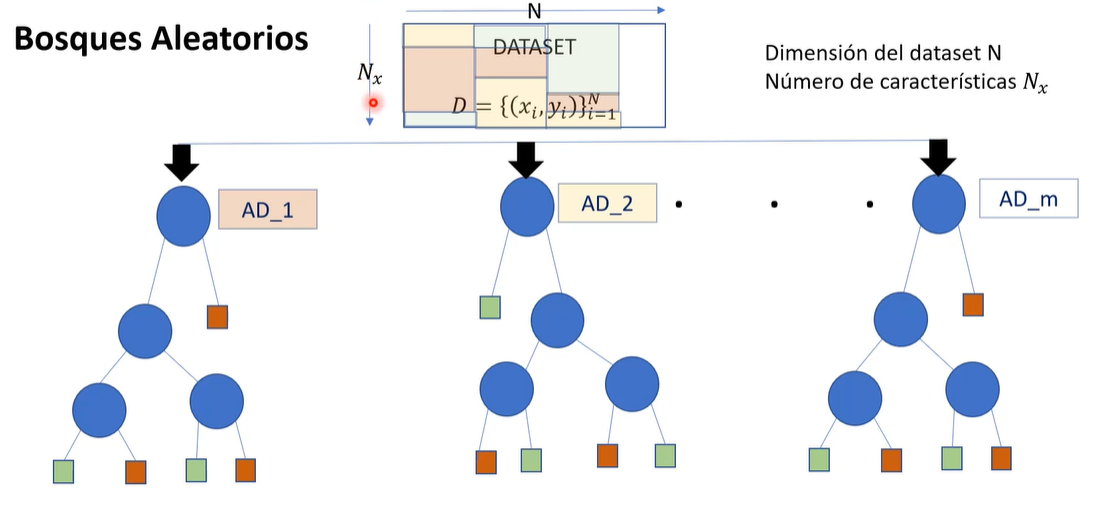



Método de ensamble basado en árboles de decisión entrenados aleatoriamente con el objetivo de disminuir la varianza y evitar sobre-entrenamiento.

## Ventajas:

*   Método robusto
*   Evita sobre-entrenamiento
*   Disminuye la varianza en la predicción respecto a los árboles de decisión
*   Prioriza las características más importantes

## Desventajas:

*   Pueden ser lentos con grandes cantidades de datos
*   La interpretación del modelo no es transparente











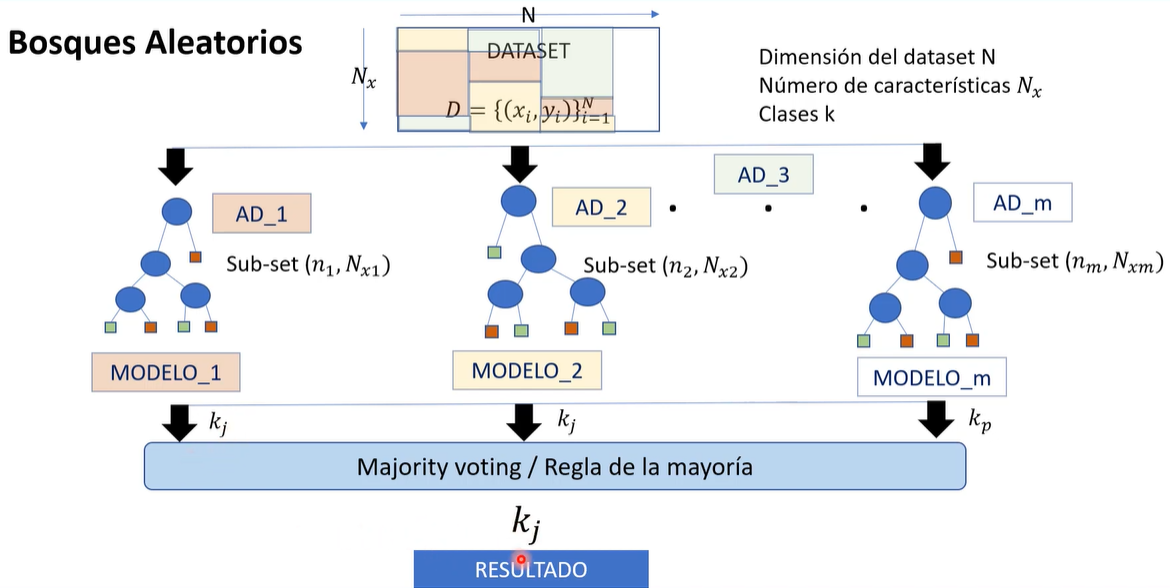

# 0. Implementación

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

# 1. Dataset Titanic

In [2]:
# Cargamos el dataset
df= pd.read_csv("/content/Titanic.csv")
# Descripción genereal del conjunto de datos
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000
mean,448.483826,0.403657,2.241913,29.621899,0.514768,0.431786,34.534323
std,258.849806,0.490976,0.836147,14.493108,0.931147,0.854517,52.968619
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.500000,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,444.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.550000
75%,677.500000,1.000000,3.000000,38.000000,1.000000,1.000000,32.750000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Cambiamos la variable categórica Sex por la variable numérica Sex_male (Donde male = 1, fremale = 0)
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,1


In [5]:
# Seleccionamos las características para el modelo
data = df[['Sex_male', 'Fare', 'Age','Pclass', 'SibSp','Survived']]
data.head()

,Sex_male,Fare,Age,Pclass,SibSp,Survived
0,1,7.2500,22.0,3,1,0
1,0,71.2833,38.0,1,1,1
2,0,7.9250,26.0,3,0,1
3,0,53.1000,35.0,1,1,1
4,1,8.0500,35.0,3,0,0


In [6]:
# Información del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sex_male  711 non-null    uint8  
 1   Fare      711 non-null    float64
 2   Age       711 non-null    float64
 3   Pclass    711 non-null    int64  
 4   SibSp     711 non-null    int64  
 5   Survived  711 non-null    int64  
dtypes: float64(2), int64(3), uint8(1)
memory usage: 28.6 KB


In [7]:
# Dividimos los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split
# X son nuestras variables independientes
X = data.drop(["Survived"],axis = 1)

# y es nuestra variable dependiente
y = data.Survived

# División 75% de datos para entrenamiento, 25% de daatos para test
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(),random_state=0)

# Modelo

In [29]:
#@title Código Arboles

#@markdown
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        
        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        if len(counter.most_common(1)) != 0:
          most_common = counter.most_common(1)[0][0]
          return most_common
        else:
          return [(0, 0)]

In [35]:
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]

def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common


class RandomForest:
    
    def __init__(self, n_trees=10, min_samples_split=2,
                 max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split,
                max_depth=self.max_depth, n_feats=self.n_feats)
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

    def score(self, X, y):
        accuracy = np.sum(y == self.predict(X)) / len(y)
        return accuracy

In [36]:
# Creaamos el modelo de Bosques Aleatorios (y configuramos el número de estimadores (árboles de decisión))
#BA_model = RandomForestClassifier(n_estimators = 19, random_state = 2016, min_samples_leaf = 8,)

BA_model = RandomForest(n_trees=19, max_depth=10)

In [37]:
X_train.shape, y_train.shape

((533, 5), (533,))

## Entrenamiento

In [38]:
BA_model.fit(X_train, y_train)

## Accuracy promedio (Usando datos de Test)

In [39]:
# Accuracy promedio
BA_model.score(X_test, y_test)

0.7921348314606742

## Matriz de Confusión

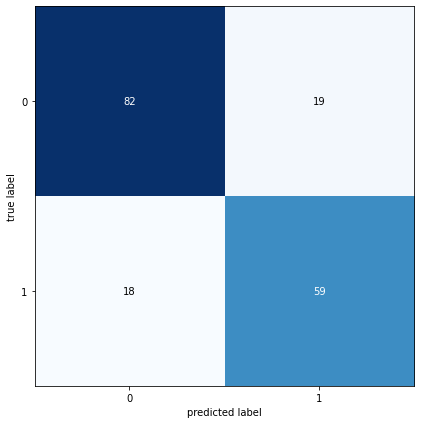

In [40]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Predicción del modelo usando los datos de prueba
y_pred = BA_model.predict(X_test)
matriz = confusion_matrix(y_test,y_pred)

plot_confusion_matrix(conf_mat=matriz, figsize=(6,6), show_normed=False)
plt.tight_layout()

Créditos a [Sistemas Inteligentes](https://youtu.be/jlJ4uKS9D5A) y material de apoyo de parte de [Python Enginner](https://youtu.be/Oq1cKjR8hNo)